In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99% !important;}</style>"))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from itertools import combinations
from scipy.cluster.vq import kmeans, kmeans2
import sys,  imutils

sys.path.append('/home/joshua/FunCode/MachineLearning/ComputerVision/')
from helpers import *
from config import *
from load import *

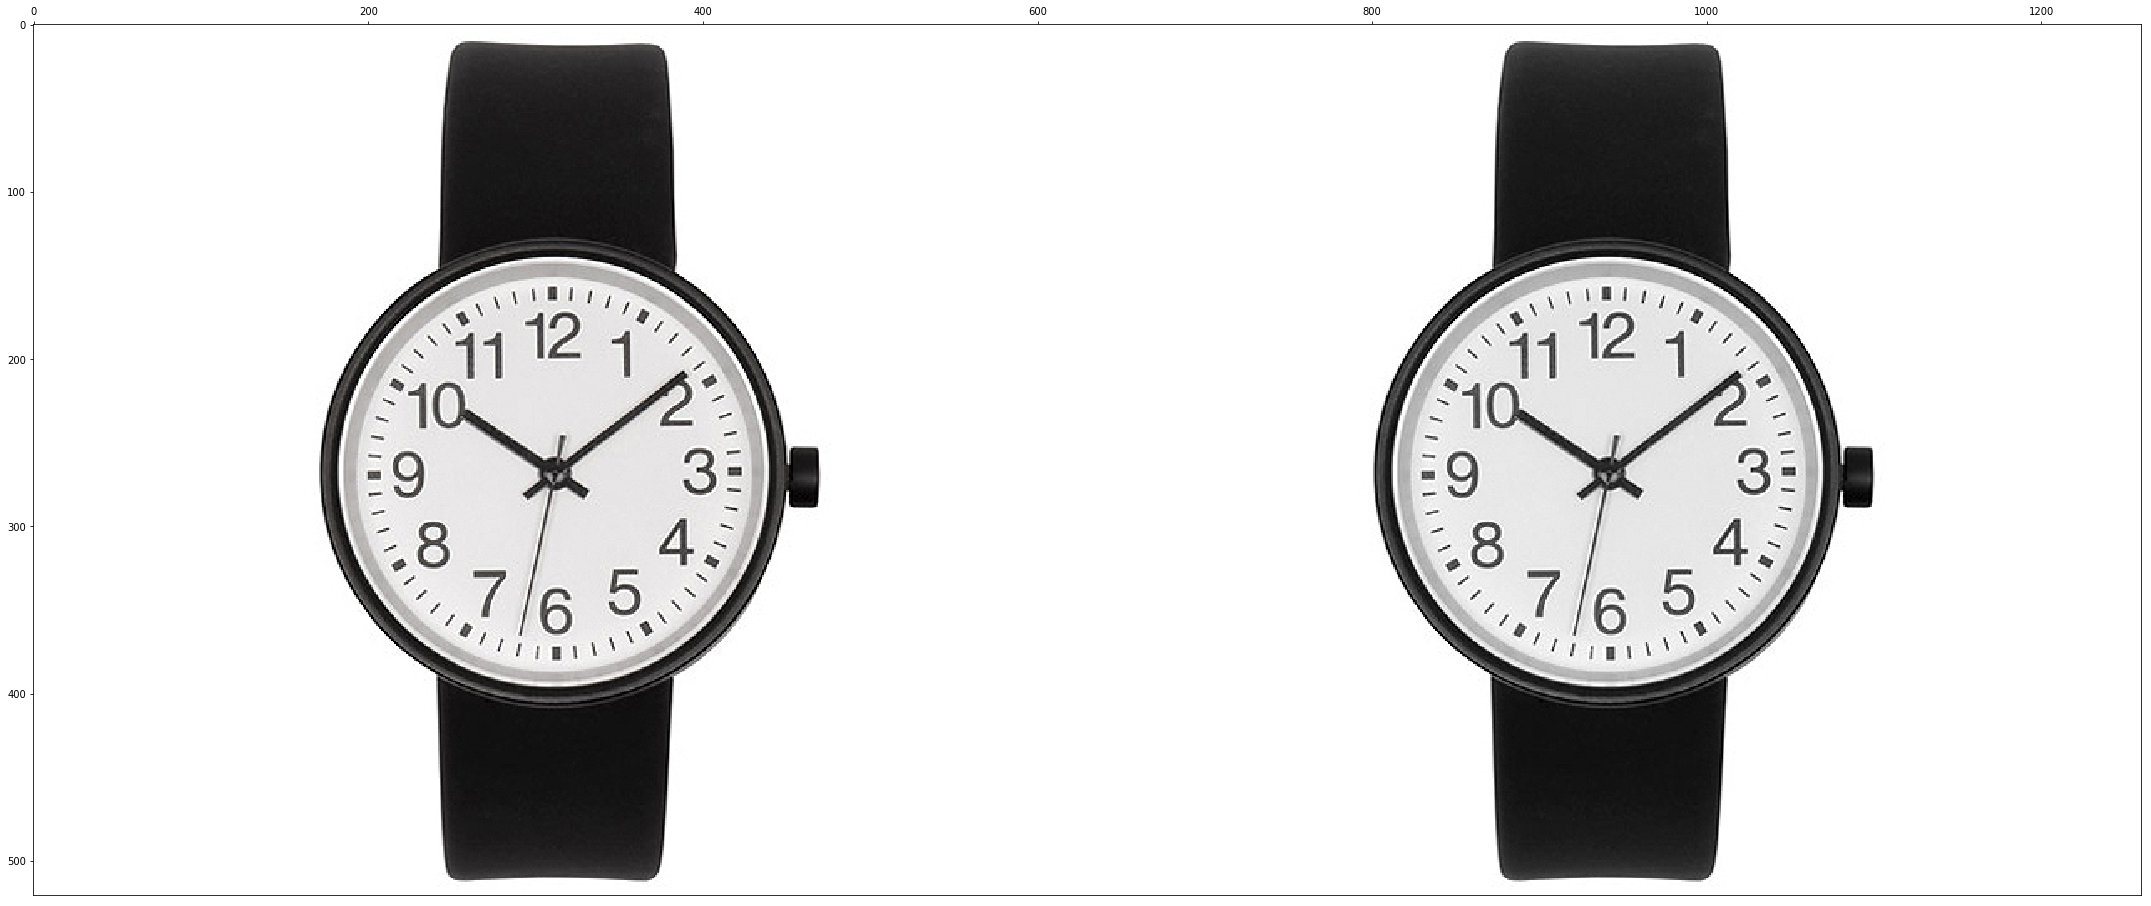

In [2]:
### Load Image
# 0 Simple Watch Unbranded  
# 1 Stock S001W  
# 2 Seiko SKX009  
# 3 Urban Outfitters  
# 4 Simple Two Hand  (Deleted, oops)

filen = 0
files = GetAllFiles(PATH)
f = files[filen]
im3 = cv.imread(f) # "3" for 3 channels
im = cv.cvtColor(im3, cv.COLOR_BGR2GRAY)
# Show raw and b/w images, converting both to RGB prior to displaying.
pltimshow(np.hstack([cv.cvtColor(im3, cv.COLOR_BGR2RGB),
                     cv.cvtColor(im, cv.COLOR_GRAY2BGR)]), figsize=(30,30))

In [3]:
### Blank (black) images for masking.
blank = np.full(im.shape, 0, dtype=np.uint8)
blank3 = np.full(im3.shape, 0, dtype=np.uint8)

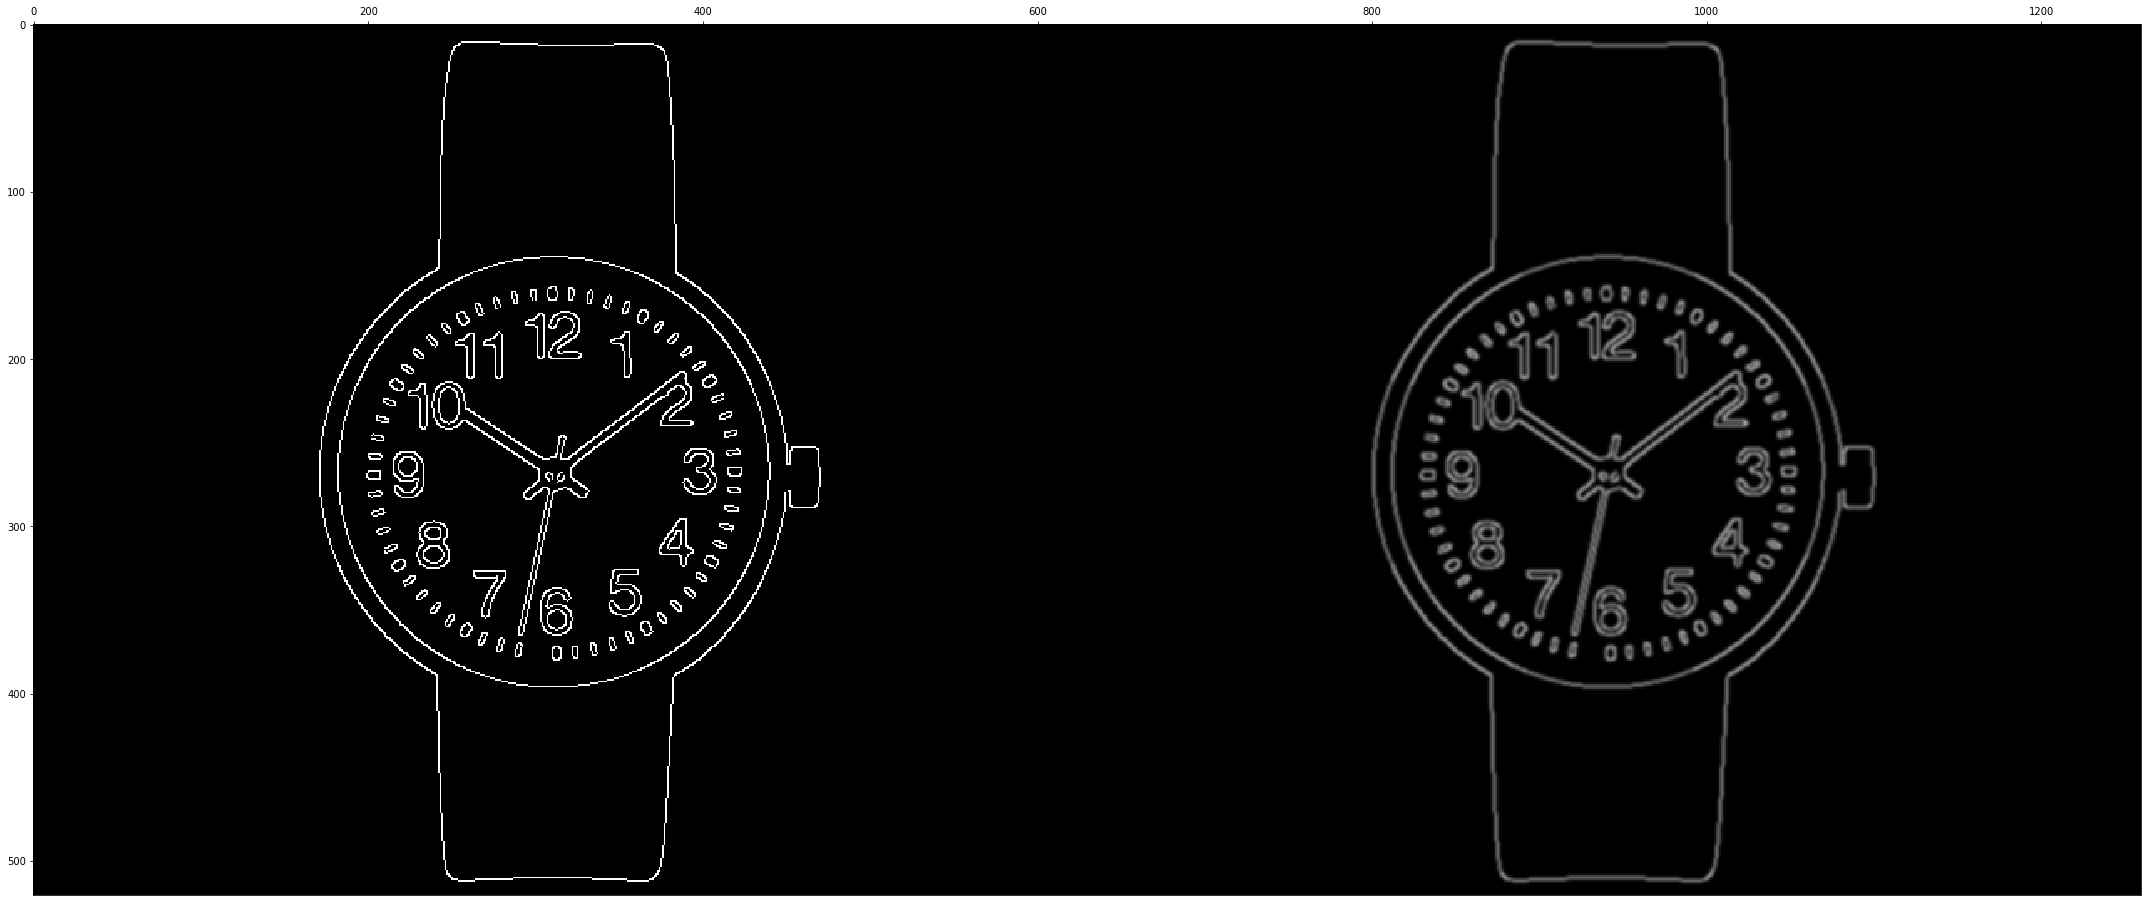

In [4]:
### Edge detection
# Blur, Canny, BlurCanny
k = 5
kernelsize = (k,k)
kernel = np.ones(kernelsize)

imb = cv.GaussianBlur(im, kernelsize, 0) # "b" for blur

edges = Canny(imb)
#pltimshow(edges)

edgesb = cv.GaussianBlur(edges.copy(), kernelsize, 0)
pltimshow(np.hstack([edges, edgesb]), figsize=(30,30))

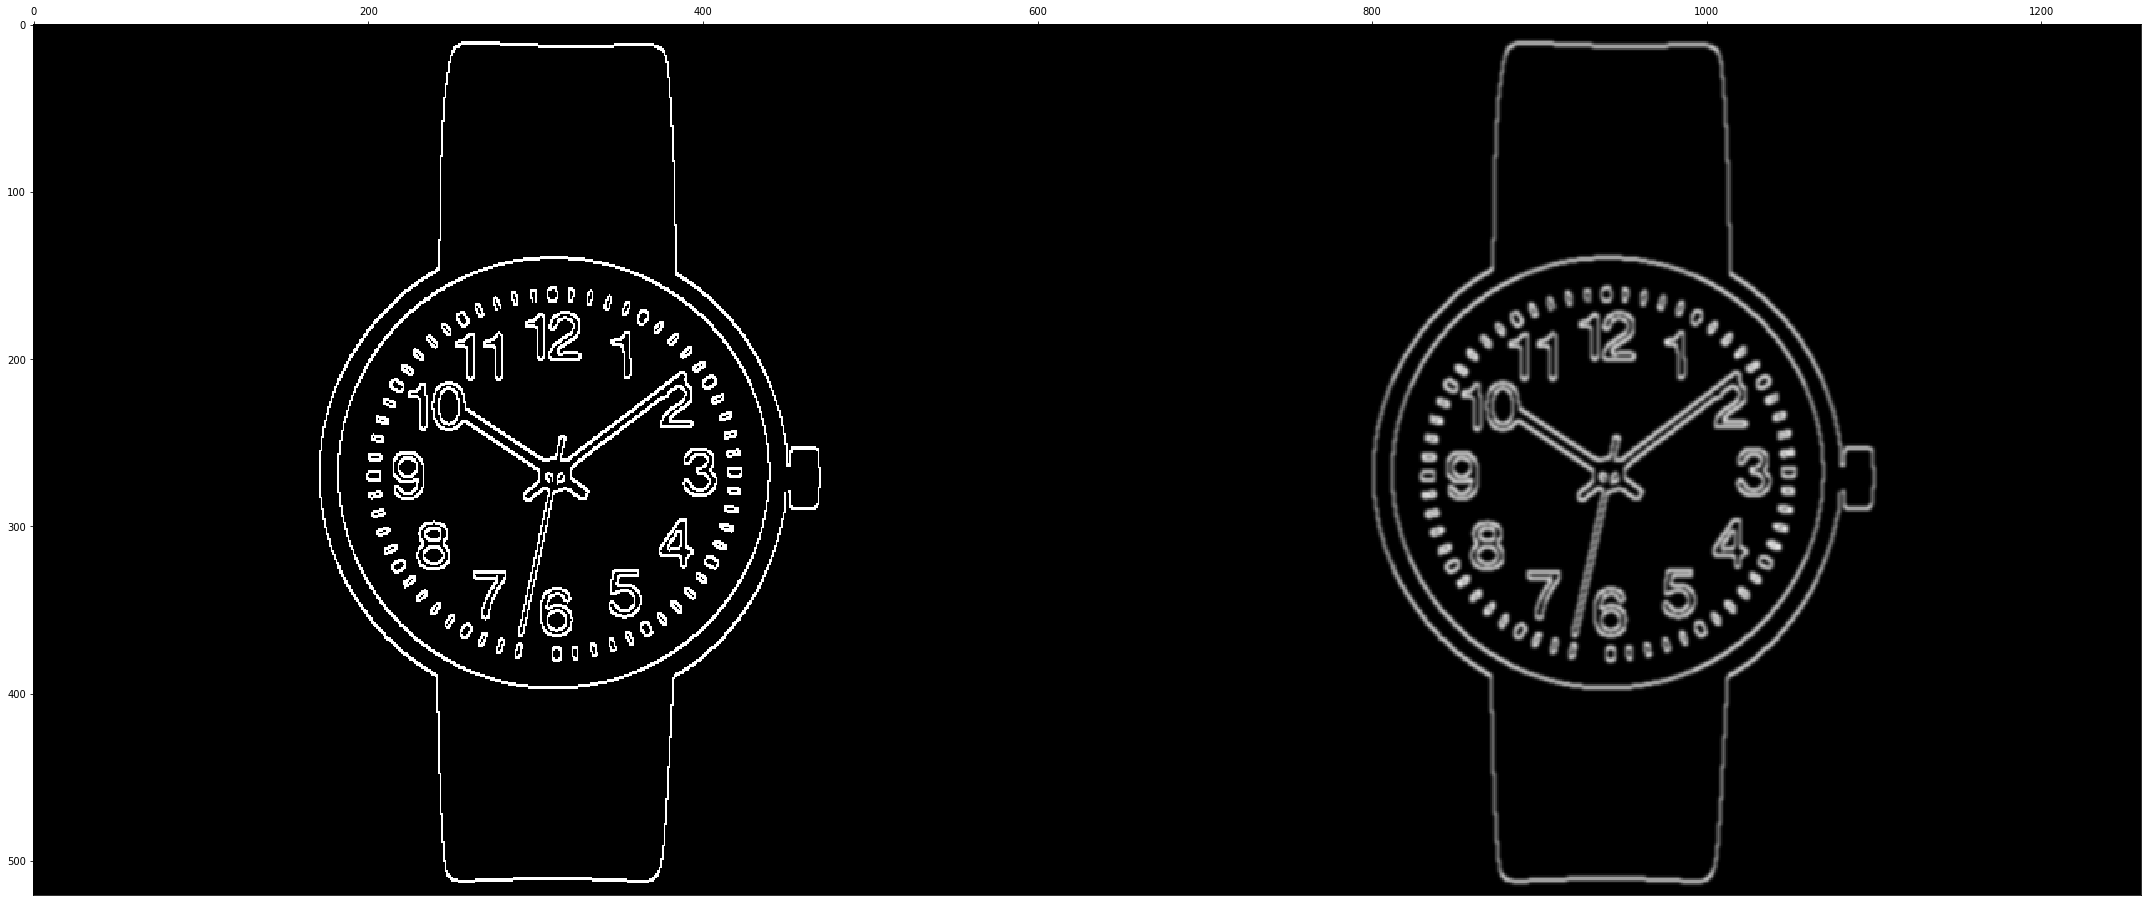

In [5]:
edgesd = cv.dilate(edges, kernelsize)
edgesdb = cv.GaussianBlur(edgesd.copy(), kernelsize, 0)
pltimshow(np.hstack([edgesd, edgesdb]), figsize=(30,30))

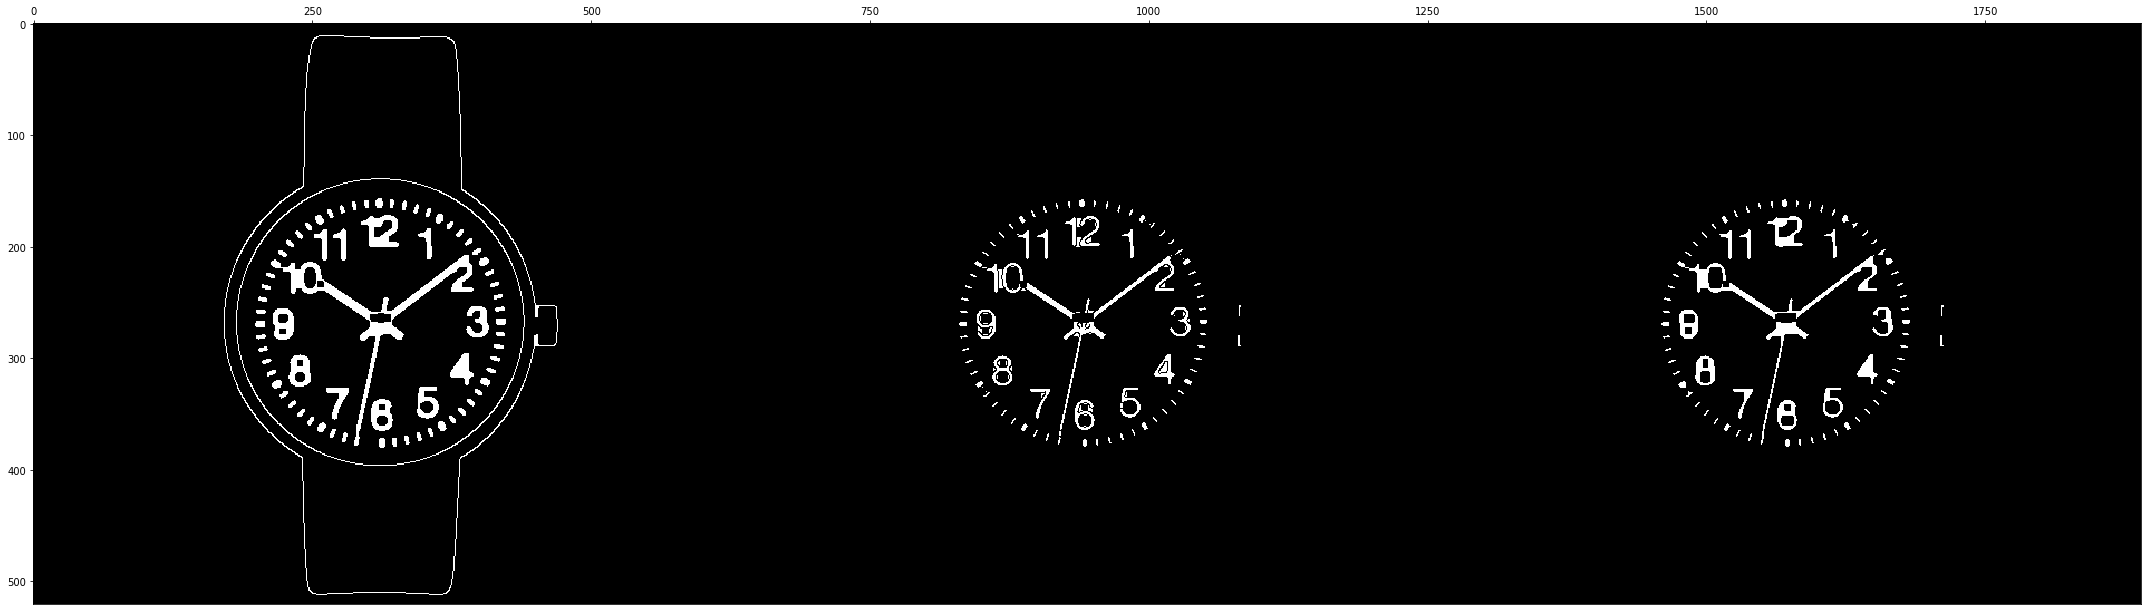

In [6]:
### Morphology
IFM = edges.copy() # Image for Morphology

closed = cv.morphologyEx(IFM, cv.MORPH_CLOSE, kernel)
blackhat = cv.morphologyEx(IFM, cv.MORPH_BLACKHAT, kernel)
blackhatclosed = cv.morphologyEx(blackhat, cv.MORPH_CLOSE, kernel)
pltimshow(np.hstack([closed, blackhat, blackhatclosed]), figsize=(30,30))

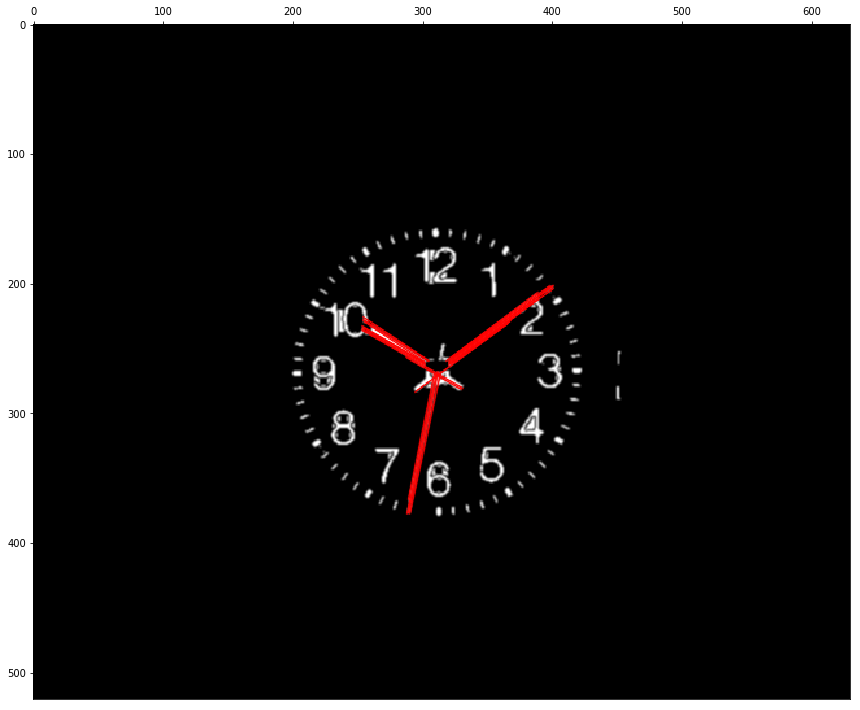

In [7]:
### Probabilistic Hough Transform
IFL = blackhat.copy() # Image For Lines
IFL = cv.GaussianBlur(IFL.copy(), (3,3), 0)
IFL3 = cv.cvtColor(IFL.copy(), cv.COLOR_GRAY2BGR)

rho = 1
theta = np.pi/180
minLineLength = 0.05 * np.sqrt(im.shape[0]**2 + im.shape[1]**2)
maxLineGap = k
threshold = int(minLineLength) + maxLineGap
lines0 = cv.HoughLinesP(IFL.copy(), rho=rho, theta=theta, threshold=threshold,
                        minLineLength=minLineLength, maxLineGap=maxLineGap)
# Redice dimensionality of lines variable, [[x,y,..]] --> [x,y,..].
lines0 = lines0[:,0]

Lines = IFL3.copy()
for x1,y1,x2,y2 in lines0:
    cv.line(Lines, (x1, y1), (x2, y2), pltRED, 1, cv.LINE_AA)
pltimshow(Lines)

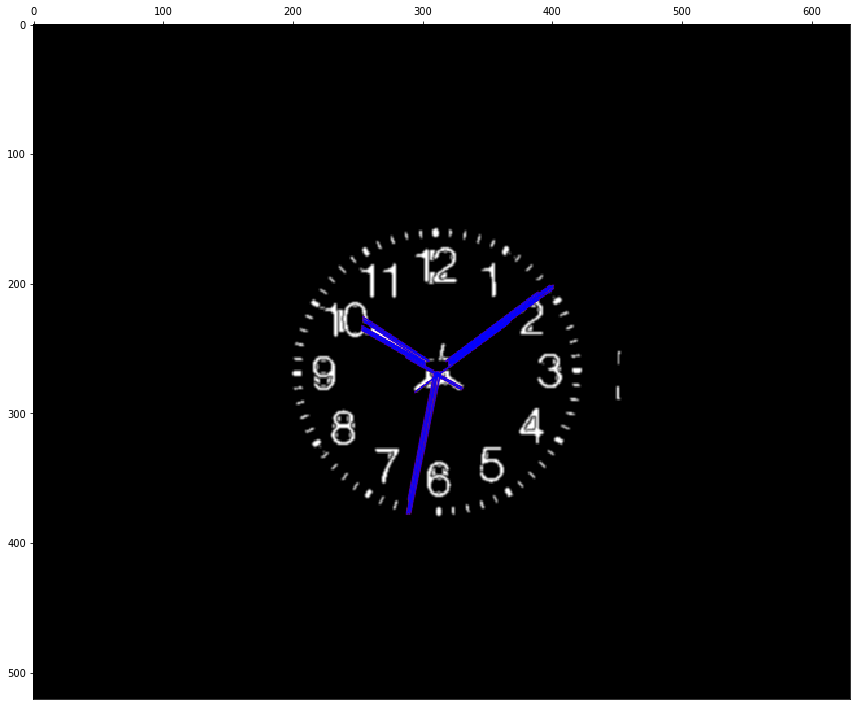

In [8]:
### Filter lines by position
# Lines at or very near edge of image are removed.
# Filter lines within p*100% of x, y. There must be a better way to code this...
# Remember (d'oh): a.shape = (y, x)
def inFrame(im, lines, p=0.2):
    minx, miny = p*im.shape[1], p*im.shape[0]
    maxx, maxy = (1-p)*im.shape[1], (1-p)*im.shape[0]
    padx1 = (minx<lines[:,0]) & (lines[:,0]<maxx)
    padx2 = (minx<lines[:,2]) & (lines[:,2]<maxx)
    pady1 = (miny<lines[:,1]) & (lines[:,1]<maxy)
    pady2 = (miny<lines[:,3]) & (lines[:,3]<maxy)
    lines = lines[padx1 & padx2 & pady1 & pady2]
    return lines

lines1 = inFrame(im, lines0)

for x1,y1,x2,y2 in lines1:
    cv.line(Lines, (x1, y1), (x2, y2), pltBLUE, 1, cv.LINE_AA)
pltimshow(Lines)

In [9]:
### K-means to cluster lines into three groups (hands)
K = 3
lines2, lines_distortion = kmeans(lines1.copy().astype(float), K)

In [10]:
print(lines0)
print(lines1)
print(lines2)

[[320 263 401 204]
 [253 235 302 263]
 [288 378 311 268]
 [289 367 309 270]
 [320 261 401 202]
 [254 229 302 261]
 [318 260 389 207]
 [289 377 312 268]
 [253 236 331 281]
 [287 257 330 282]
 [290 378 314 268]
 [323 257 398 202]
 [254 228 304 260]
 [253 233 301 261]
 [294 284 366 231]
 [320 262 389 212]
 [254 234 302 262]
 [254 226 305 260]
 [322 262 368 229]
 [320 260 400 202]]
[[320 263 401 204]
 [253 235 302 263]
 [288 378 311 268]
 [289 367 309 270]
 [320 261 401 202]
 [254 229 302 261]
 [318 260 389 207]
 [289 377 312 268]
 [253 236 331 281]
 [287 257 330 282]
 [290 378 314 268]
 [323 257 398 202]
 [254 228 304 260]
 [253 233 301 261]
 [294 284 366 231]
 [320 262 389 212]
 [254 234 302 262]
 [254 226 305 260]
 [322 262 368 229]
 [320 260 400 202]]
[[289.    375.    311.5   268.5  ]
 [257.75  234.75  309.625 266.25 ]
 [317.125 263.625 389.    211.125]]


In [11]:
### Get intersections for hand hand centers. Trim by intersections outside image.
def getIntersections(line1, line2):
    '''https://stackoverflow.com/a/42727584'''
    m = np.hstack([np.reshape(np.array([line1, line2]), (4,2)), np.ones((4,1))])
    l1 = np.cross(m[0], m[1])
    l2 = np.cross(m[2], m[3])
    x, y, z = np.cross(l1, l2)
    if not z:
        return np.array([np.inf, np.inf])
    return np.array([x/z, y/z])

centers = np.array([getIntersections(i,j) for i,j in combinations(lines2,2)])
centers = centers[(0<centers[:,0]) & (0<centers[:,1]) & 
                  (centers[:,0]<im.shape[0]) & (centers[:,1]<im.shape[0])]
#center = np.mean(centers, axis=0)
center = np.median(centers, axis=0)
print(center)

[311.708114   267.54523026]


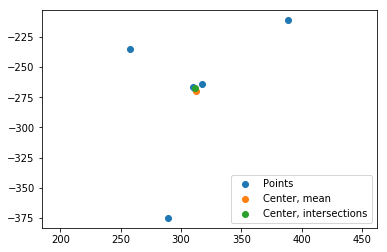

In [12]:
points = lines2.reshape(-1,2)
# Reverse Y for image:array transform. Only for plotting.
p = points.copy() * [1, -1]
plt.scatter(*p.T, label='Points')
plt.scatter(*p.mean(axis=0), label='Center, mean')
plt.scatter(*center * [1, -1], label='Center, intersections')
plt.axis('equal')
plt.legend(); plt.show()

In [13]:
# Transform image-referenced lines (x1,y1,x2,y2) to zero-referenced individual coordinates (x,y).
# Find and sort by L2 norm. Set the three lines associated with the three coordinated with lowest
# norm to line intersection center. Only keep the three coordinates and associated norms with
# highest norm.
points = lines2.reshape(-1,2) - center
r = np.sqrt(np.sum(points**2, axis=1))
lines2.reshape(-1,2)[r.argsort()[:K]] = center
points = points[r.argsort()][-K:]
r = r[r.argsort()][-K:]

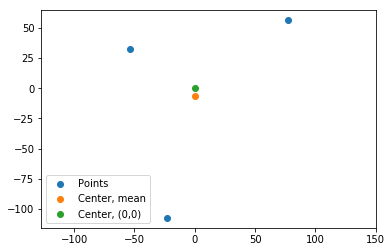

In [14]:
# Reverse Y for image:array transform. Only for plotting.
p = points.copy() * [1, -1]
plt.scatter(*p.T, label='Points')
plt.scatter(*p.mean(axis=0), label='Center, mean')
plt.scatter(*[0,0], label='Center, (0,0)')
plt.axis('equal')
plt.legend(); plt.show()

In [15]:
# print(points.mean(axis=0))
# print(center)
# center2 = np.array([(points+center).mean(axis=0), center]).mean(axis=0)
# print(center2)

In [16]:
# # Reverse Y for image:array transform. Only for plotting.
# p = points.copy() * [1, -1]
# plt.scatter(*p.T)
# plt.scatter(*p.mean(axis=0))
# plt.scatter(*[0,0])
# plt.scatter(*center2-center)
# plt.axis('equal')
# plt.show()

In [17]:
def NormalizePoints(points, recenter=False):
    '''Assumes points are of form np.array([[-55,-77], [50,-45], [-60,60]])
    and shortest-longest hands are of order (h, m, s) (array is not necessarily
    in order, however). Takes points, returns sorted points with reference
    point as center of points'''

    if recenter:
        points = points - points.mean(axis=0)
        center = np.array([0,0])
    else:
        center = points.mean(axis=0)

    # Order hands shortest-longest == (h, m, s) via L2 norm.
    r = np.sqrt(np.sum((points-center)**2, axis=1))
    points = points[r.argsort()]

    return points, center, r


def Points2Time(points, recenter=False, orientation=0):
    '''Assumes points are of form np.array([[-55,-77], [50,-45], [-60,60]])
    and shortest-longest hands are of order (h, m, s) (array is not
    necessarily in order, however).'''

    points, center, r = NormalizePoints(points, recenter=recenter)

    theta_rad = np.arctan(points[:,1]/points[:,0])
    theta_rad2 = np.arctan2(points[:,1], points[:,0])

    # +270 degrees for math --> clock convention
    theta_deg = theta_rad * 180/np.pi + 270 + orientation

    # Rotate theta[i] 180 degrees if sign(atan[i]) == sign(atan2[i]).
    # Modulo 360 for overflow. I could -1*x, y points, but adding
    # 180 degrees to appropriate thetas works fine here.
    arctans_are_same = np.sign(theta_rad) == np.sign(theta_rad2)
    rotate180 = arctans_are_same * 180

    theta_deg = (theta_deg + rotate180)%360

    if len(theta_deg) == 2:
        time = theta_deg / (30, 6)
        hour, minute = time.astype(int)
        second = 0
    elif len(theta_deg) == 3:
        time = theta_deg / (30, 6, 6)
        hour, minute, second = time.astype(int)
    

    if not hour: hour = 12
    time_str = '{0:02}:{1:02}:{2:02} AM/PM'.format(hour, minute, second)

    return time, time_str

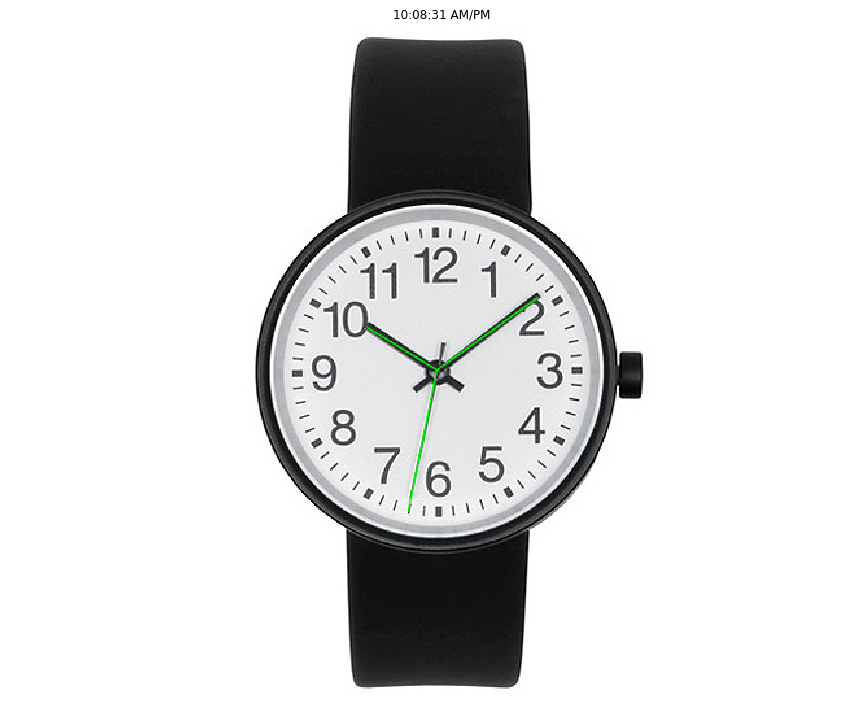

In [19]:
if filen == 0: orientation = 0
elif filen == 1: orientation = 90
elif filen == 2: orientation = 30
else: orientation = 0
    
time, time_str = Points2Time(points, orientation=orientation)

imLines = im3.copy()
for x1,y1,x2,y2 in lines2.astype(int):
    cv.line(imLines, (x1, y1), (x2, y2), GREEN, 1, cv.LINE_AA)
pltimshow(imLines, title=time_str, axes=False, save=True, savename='Plots/time{}.png'.format(filen))

# Or use KMeans on points instead of lines

In [152]:
# ### K-means to cluster line endpoints into three+1 groups (hands+center)
# points, points_distortion = kmeans(lines1.reshape(-1,2).copy().astype(float), K+1)
# p = np.median(points, axis=0)
# #p = np.mean(points, axis=0)
# #print(points, p)

In [153]:
# # Loop to further reduce difference. Kind of like a mini K-means.
# # Takes about 4 iter for c to overflow to 0 precisely.
# for i in range(4):
#     c0 = points.mean(axis=0)
#     r = np.sqrt(np.sum((points - c0)**2, axis=1))
#     points = points[r.argsort()][-K:] - c0
#     c = points.mean(axis=0)
#     print(i, c0, '-->', c)

In [154]:
# # Reverse Y for image:array transform. Only for plotting.
# t = points*[1, -1]
# plt.scatter(*t.T)
# plt.scatter(*np.mean(t, axis=0))
# plt.scatter(*np.median(t, axis=0))
# plt.axis('equal')
# plt.show()

In [155]:
# lines = np.hstack([points+p, [c]*K+p])

In [23]:
### K-means to cluster line endpoints into three+1 groups (hands+center)
points, points_distortion = kmeans(lines1.reshape(-1,2).copy().astype(float), K+1)

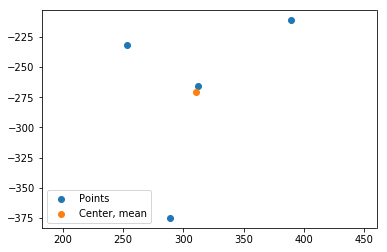

In [24]:
# Reverse Y for image:array transform. Only for plotting.
p = points.copy() * [1, -1]
plt.scatter(*p.T, label='Points')
plt.scatter(*p.mean(axis=0), label='Center, mean')
plt.axis('equal')
plt.legend(); plt.show()

In [25]:
# Find point nearest mean. This must be center. Points2Time only takes one point per hand (no center), 
# so we must remove the center-point from the points list, but keeping it to create lines to plot.
# Then subtract it from other points so Points2Time has zero-centered points.
r = np.sqrt(np.sum((points - points.mean(axis=0))**2, axis=1))
center = points[r.argsort()][0]
points = points[r.argsort()][-K:]
lines = np.hstack([points, [center]*K])
points -= center

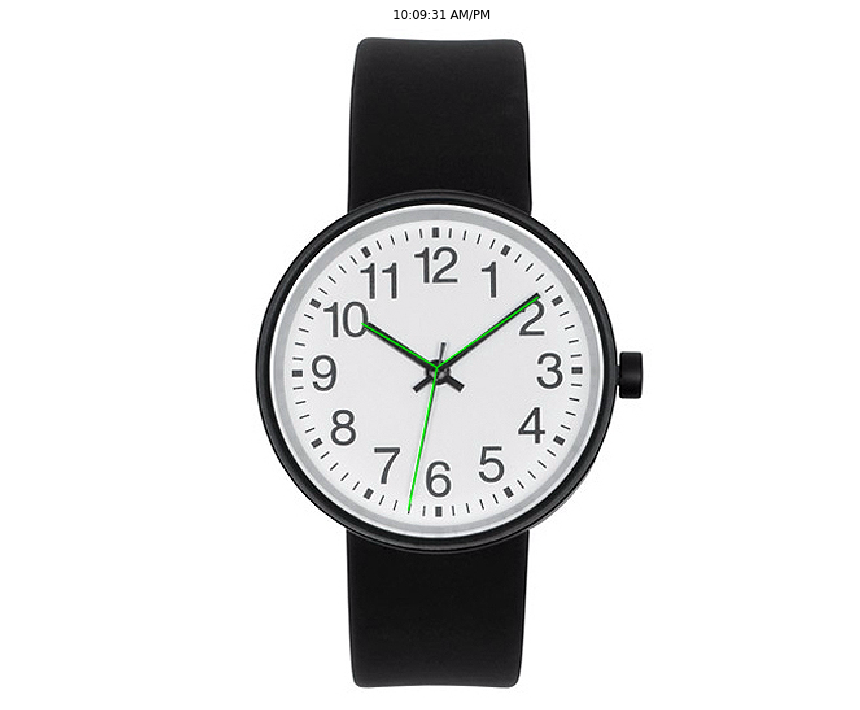

In [26]:
time, time_str = Points2Time(points, orientation=orientation)

imLines = im3.copy()
for x1,y1,x2,y2 in lines.astype(int):
    cv.line(imLines, (x1, y1), (x2, y2), GREEN, 1, cv.LINE_AA)
pltimshow(imLines, title=time_str, axes=False, save=False, savename='Plots/time{}.png'.format(filen))